2d ISING MODEL (h=0) 

$$ W_{ia} = \begin{bmatrix}
    \sqrt{\cosh(\beta)} & \sqrt{\sinh(\beta)} \\
    \sqrt{\cosh(\beta)} &  -\sqrt{\sinh(\beta)}
\end{bmatrix}$$ 

Then, $$ T_{abcd} = W_{ia}W_{ib}W_{ic}W_{id} $$ 

Let us define $$ \kappa =\frac{\sinh (2 \beta)}{2 \cosh ^2(2 \beta)} $$
and then the free energy density is given by: 
$$ f = -\frac{1}{\beta} \Bigg(\log (2 \cosh (2 \beta))-\kappa ^2 \, _4F_3\left(1,1,1.5,1.5;2,2,2;16 \kappa ^2\right)\Bigg) $$ 

The critical temperature is given by:

$$ T_{c} = \frac{2}{\log (1 + \sqrt{2})} = 2.26918531421 $$  
i.e. $$ \beta_{c} \approx 0.44069 $$ 

which is obtained by solving 

$$ \sinh(2\beta_{c}) = 1 $$. 




---



We numerically compute the free energy here using tensor networks.


STARTED:  2020-06-11 19:20:24
0.38 -2.2585810248911287
0.3805 -2.2569373791527867
0.381 -2.25530108607246
0.3815 -2.253672126919903
0.382 -2.2520504831632837
0.3825 -2.250436136469664
0.383 -2.248829068705542
0.3835 -2.2472292619373975
0.384 -2.2456366984323357
0.3845 -2.2440513606587276
0.385 -2.2424732312869278
0.3855 -2.2409022931900426
0.386 -2.239338529444723
0.3865 -2.2377819233320473
0.387 -2.236232458338423
0.3875 -2.2346901181565686
0.388 -2.233154886686539
0.3885 -2.2316267480368235
0.389 -2.2301056865254862
0.3895 -2.2285916866813893
0.39 -2.227084733245473
0.3905 -2.2255848111721
0.391 -2.224091905630482
0.3915 -2.2226060020061595
0.392 -2.2211270859025816
0.3925 -2.2196551431427425
0.393 -2.2181901597709186
0.3935 -2.216731564074719
0.394 -2.2152804515758624
0.3945 -2.2138362578829422
0.395 -2.2123989699448683
0.3955 -2.21096857494186
0.396 -2.209545060287751
0.3965 -2.2081284136323736
0.397 -2.206718622864073
0.3975 -2.205315676112356
0.398 -2.203919561750621
0.3985 -2.20

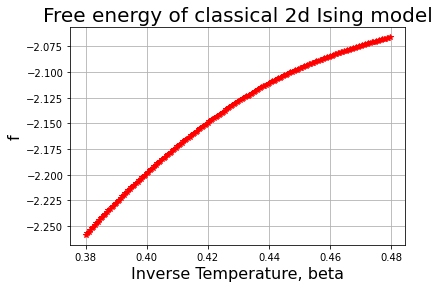

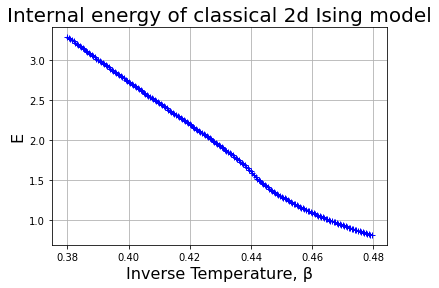

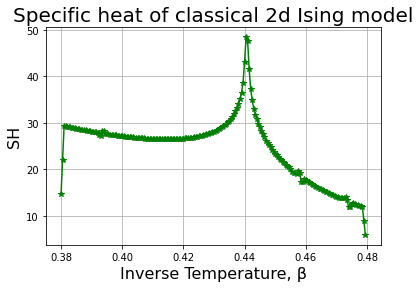

Specific heat peaks at β =  0.44050000000000006
COMPLETED:  2020-06-11 19:20:49


In [11]:
import sys
import math
from math import sqrt
import numpy as np  
from scipy import special
from numpy import linalg as LA
import scipy as sp 
import time
import datetime 
from ncon import ncon
from matplotlib import pyplot as plt
# For T=2.0, f_2d_Ising = -2.05158
# This can be checked by using exact expression.
D=8
Niters=12  # 2^12 x 2^12 square 
h=0.0   #

L = np.zeros([D])
A = np.zeros([D])
startTime = time.time()
print ("STARTED: " , datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")) 

def tensorsvd(input,left,right,D):
    '''Reshape an input tensor into a rectangular matrix with first index corresponding
    to left set of indices and second index corresponding to right set of indices. Do SVD
    and then reshape U and V to tensors [left,D] x [D,right]  
    '''
    T = input 
    left_index_list = []
    for i in range(len(left)):
        left_index_list.append(T.shape[i])
    xsize = np.prod(left_index_list) 
    right_index_list = []
    for i in range(len(left),len(left)+len(right)):
        right_index_list.append(T.shape[i])
    ysize = np.prod(right_index_list)
    T = np.reshape(T,(xsize,ysize))
    
    
    U, s, V = np.linalg.svd(T,full_matrices = False)
    
    if D < len(s):  # Truncate if length exceeds input D 
        s = np.diag(s[:D])
        U = U[:,:D]
        V = V[:D,:]
    else:
        D = len(s)
        s = np.diag(s)

    U = np.reshape(U,left_index_list+[D])
    V = np.reshape(V,[D]+right_index_list)   
    return U, s, V

 
def Z2d_Ising(beta):
  
    a = np.sqrt(np.cosh(beta)) 
    b = np.sqrt(np.sinh(beta)) 
    W = np.array([[a,b],[a,-b]]) 
    out = np.einsum("ia, ib, ic, id  -> abcd", W, W, W, W) 
    return out 

def CG_step(matrix, in2):

    T = matrix  
    TI = in2 
    AAdag = ncon([T,T,T,T],[[-2,1,2,5],[-1,5,3,4],[-4,1,2,6],[-3,6,3,4]])
    U, s, V = tensorsvd(AAdag,[0,1],[2,3],D) 
    A = ncon([U,T,T,U],[[1,2,-1],[2,-2,4,3],[1,3,5,-4],[5,4,-3]])

    AAAAdag = ncon([A,A,A,A],[[1,-1,2,3],[2,-2,4,5],[1,-3,6,3],[6,-4,4,5]])
    U, s, V = tensorsvd(AAAAdag,[0,1],[2,3],D)  
    AA = ncon([U,A,A,U],[[1,2,-2],[-1,1,3,4],[3,2,-3,5],[4,5,-4]])

    maxAA = np.max(AA)
    AA = AA/maxAA # Normalize by largest element of the tensor
        
    return AA, maxAA


if __name__ == "__main__":

    beta = np.arange(0.38, 0.48, 0.0005).tolist()
    Nsteps = int(np.shape(beta)[0])
    f = np.zeros(Nsteps)

    for p in range (0, Nsteps):

      #print ("β =", round(beta[p],5))
      T = Z2d_Ising(beta[p])
      norm = LA.norm(T)
      T /= norm 
      Tim = T 
      Z = ncon([T,T,T,T],[[7,5,3,1],[3,6,7,2],[8,1,4,5],[4,2,8,6]])
      C = 0
      N = 1
      C = np.log(norm)
      Free = -(1.0/beta[p])*(np.log(Z)+4*C)/(4*N)

      for i in range (Niters):


          T, norm = CG_step(T, Tim)
          C = np.log(norm)+4*C
          N *= 4.0
          Free = -(1.0/beta[p])*(np.log(Z)+4*C)/(4*N) 
          if i == Niters-1:

            Z1 = ncon([T,T],[[1,-1,2,-2],[2,-3,1,-4]])
            Z = ncon([Z1,Z1],[[1,2,3,4],[2,1,4,3]])
            Free = -(1.0/beta[p])*(np.log(Z)+4*C)/(4*N)
            f[p] = Free 
            #print (round(beta[p],5), Free)
    
    dx = beta[1]-beta[0] # Asssuming equal spacing ...
    dfdx = np.gradient(f, dx)
    d2fdx2 = np.gradient(dfdx, dx)
    plt.plot(beta, f, marker="*", color = "r")
    plt.grid(True)
    plt.title('Free energy of classical 2d Ising model', fontsize=20)
    plt.xlabel('Inverse Temperature, beta', fontsize=16)
    plt.ylabel('f', fontsize=16)
    plt.show()  
    # Now plot internal energy 'E' 
    plt.plot(beta, dfdx, marker="+", color = "b")
    plt.grid(True)
    plt.title('Internal energy of classical 2d Ising model', fontsize=20)
    plt.xlabel('Inverse Temperature, β', fontsize=16)
    plt.ylabel('E', fontsize=16)
    plt.show()
    plt.plot(beta, -d2fdx2, marker="*", color = "g")
    plt.grid(True)
    # 
    plt.title('Specific heat of classical 2d Ising model', fontsize=20)
    plt.xlabel('Inverse Temperature, β', fontsize=16)
    plt.ylabel('SH', fontsize=16)
    plt.show()
    print ("Specific heat peaks at β = ", beta[int(np.array(-d2fdx2).argmax())])
    print ("COMPLETED: " , datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))